In [1286]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, sosfiltfilt, sosfilt

def get_spherical(x, y, z):
    r = (x**2 + y**2 + z**2)**0.5
    theta = np.arccos(z / r)  # polar angle
    phi = np.arctan2(y, x)  # azimuthal angle
    return r, theta, phi

def print_err_stats(x, gt, prefix=""):
    error = x - gt
    rmse = np.mean(error ** 2) ** 0.5
    mae = np.mean(abs(error))
    me = np.mean(error)
    print(f"{prefix} RMSE: {rmse:.3f}, MAE: {mae:.3f}, ME: {me:.3f}")

In [1287]:
log_filename = "log022.csv"
df = pd.read_csv("logs/" + log_filename)
time = df["t_ms"].values
time_s = time / 1000
mag_raw = df[["mmc_mG_x", "mmc_mG_y", "mmc_mG_z"]].values
angle_raw = df["angle_raw"].values * np.pi * 2 / 4096
accel_proj = np.load(f"net_accel_projected_{log_filename}.npy")

slice_time = False

# Get a time slice
if slice_time:
    start_time = 20000  # ms
    end_time = 40000  # ms
    mask = (time >= start_time) & (time <= end_time)
    time = time[mask]
    mag_raw = mag_raw[mask]
    angle_raw = angle_raw[mask]
    accel_proj = accel_proj[mask]

In [1288]:
def fft_and_histogram(x, fs=100.0, detrend=True, window="hann",
                      hist_bins=80, hist_log=True, eps=1e-12):
    """
    x: 1D array of samples (sensor signal)
    fs: sample rate in Hz (100 by default)
    detrend: remove mean to kill DC offset
    window: "hann", "hamming", or None
    hist_bins: number of histogram bins
    hist_log: histogram of log10 magnitudes (usually nicer)
    eps: small number to avoid log(0)
    """
    x = np.asarray(x).astype(float)
    n = x.size

    if detrend:
        x = x - np.mean(x)

    if window is None:
        w = np.ones(n)
    elif window.lower() == "hann":
        w = np.hanning(n)
    elif window.lower() == "hamming":
        w = np.hamming(n)
    else:
        raise ValueError("window must be 'hann', 'hamming', or None")

    xw = x * w

    # One-sided real FFT
    X = np.fft.rfft(xw)
    f = np.fft.rfftfreq(n, d=1.0/fs)

    # Amplitude spectrum (approx. amplitude-corrected for window + one-sided)
    # This gives a reasonable "amplitude per bin" style magnitude.
    # For noise-floor / comparisons, dB is often more informative anyway.
    w_gain = np.sum(w) / n
    mag = (2.0 / n) * np.abs(X) / max(w_gain, eps)
    mag[0] = mag[0] / 2.0  # don't double DC
    if n % 2 == 0:
        mag[-1] = mag[-1] / 2.0  # don't double Nyquist (only if it exists)

    # dB magnitude (optional, handy for plotting)
    mag_db = 20.0 * np.log10(mag + eps)

    # ---- Plot spectrum ----
    plt.figure(figsize=(10,4))
    plt.subplot(1, 2, 1)
    plt.plot(f, mag)  # linear magnitude
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude")
    plt.title("FFT Magnitude Spectrum (one-sided)")
    plt.grid(True)

    #plt.figure()
    plt.subplot(1, 2, 2)
    plt.plot(f, mag_db)  # dB magnitude
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Magnitude (dB)")
    plt.title("FFT Magnitude Spectrum (dB)")
    plt.grid(True)

    # ---- Histogram of magnitudes ----
    # plt.figure()
    # if hist_log:
    #     vals = np.log10(mag + eps)
    #     plt.hist(vals, bins=hist_bins)
    #     plt.xlabel("log10(FFT magnitude)")
    #     plt.title("Histogram of FFT magnitudes (log10)")
    # else:
    #     plt.hist(mag, bins=hist_bins)
    #     plt.xlabel("FFT magnitude")
    #     plt.title("Histogram of FFT magnitudes")
    # plt.ylabel("Count")
    # plt.grid(True)

    plt.show()

    return f, mag, mag_db

# Example usage:
# x = np.loadtxt("sensor.csv")  # or however you load your data
# f, mag, mag_db = fft_and_histogram(x, fs=100.0)


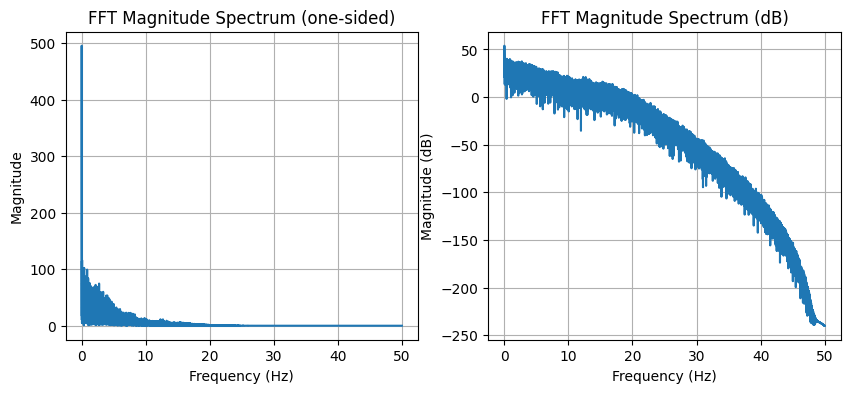

(array([0.00000000e+00, 1.26377515e-03, 2.52755030e-03, ...,
        4.99974724e+01, 4.99987362e+01, 5.00000000e+01], shape=(39565,)),
 array([1.20303109e+01, 4.95454235e+02, 4.35419186e+02, ...,
        1.76549580e-14, 4.97838164e-14, 8.09185575e-15], shape=(39565,)),
 array([  21.605537  ,   53.9000709 ,   52.77815123, ..., -239.84798894,
        -239.57800253, -239.92999788], shape=(39565,)))

In [1289]:
# Get magnetometer data and filter and convert to spherical coordinates
fc_hz = 20
fs = 100

sos = butter(N=4, Wn=fc_hz, btype="low", fs=fs, output="sos")

mag_sp = np.array([get_spherical(x, y, z) for x, y, z in mag_raw])
mag_filtered = sosfiltfilt(sos, mag_raw, axis=0)
mag_filt_sp = np.array([get_spherical(x, y, z) for x, y, z in mag_filtered])

fft_and_histogram(mag_filtered[:, 0], fs=100.0, detrend=True, window="hann",
                      hist_bins=30, hist_log=True, eps=1e-12)

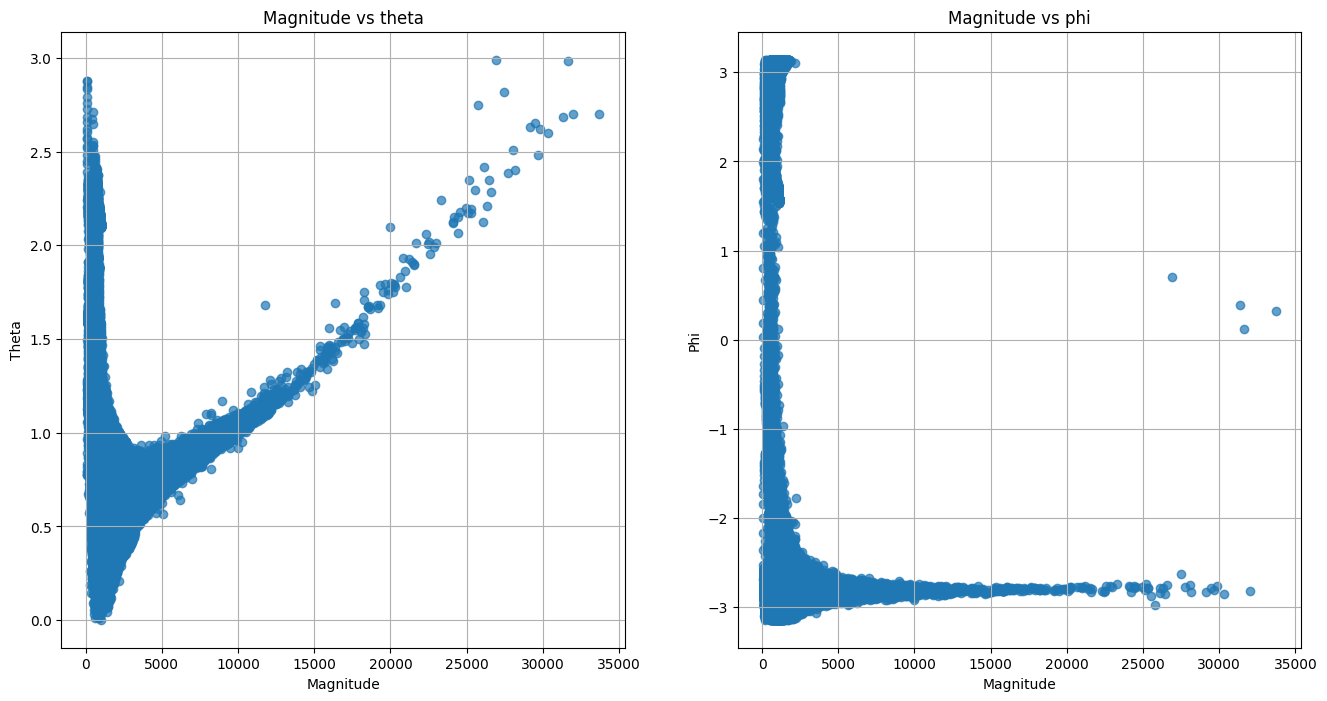

In [1290]:
# Plot scatter of magnet angle vs magnitude
# Scatter plot of vectors
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(mag_filt_sp[:, 0], mag_filt_sp[:, 1], alpha=0.7)
plt.title("Magnitude vs theta")
plt.xlabel("Magnitude")
plt.ylabel("Theta")
plt.grid()
plt.subplot(1, 2, 2)
plt.scatter(mag_filt_sp[:, 0], mag_filt_sp[:, 2], alpha=0.7)
plt.title("Magnitude vs phi")
plt.xlabel("Magnitude")
plt.ylabel("Phi")
plt.grid()
plt.show()

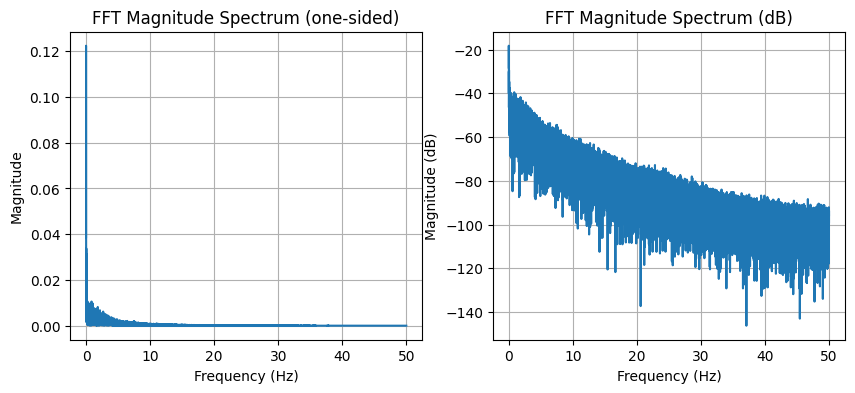

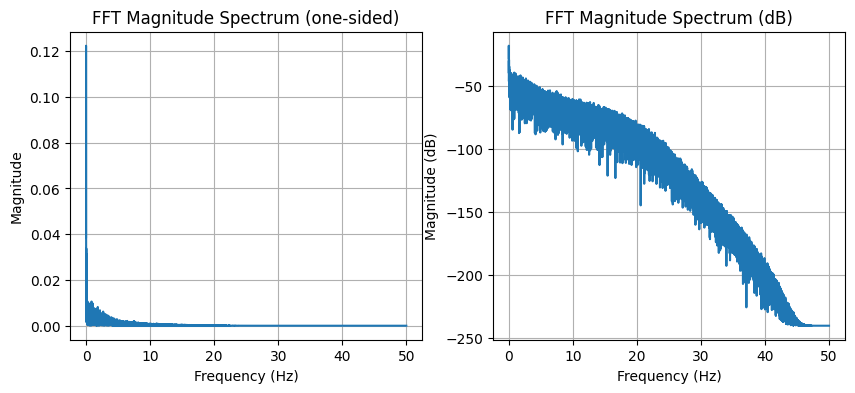

(array([0.00000000e+00, 1.26377515e-03, 2.52755030e-03, ...,
        4.99974724e+01, 4.99987362e+01, 5.00000000e+01], shape=(39565,)),
 array([3.87457508e-02, 9.70130434e-02, 1.22377376e-01, ...,
        5.74705664e-18, 1.28508093e-17, 0.00000000e+00], shape=(39565,)),
 array([ -28.23551838,  -20.26339742,  -18.24597728, ..., -239.99995008,
        -239.99988838, -240.        ], shape=(39565,)))

In [1291]:
# Get angle data and filter it
fc_hz = 20
fs = 100

angle_data = angle_raw# * 360 / 4096  # convert from raw to degrees
sos = butter(N=4, Wn=fc_hz, btype="low", fs=fs, output="sos")
angle_filtered = sosfiltfilt(sos, angle_data)

fft_and_histogram(angle_data, fs=100.0, detrend=True, window="hann",
                      hist_bins=80, hist_log=True, eps=1e-12)
fft_and_histogram(angle_filtered, fs=100.0, detrend=True, window="hann",
                      hist_bins=80, hist_log=True, eps=1e-12)


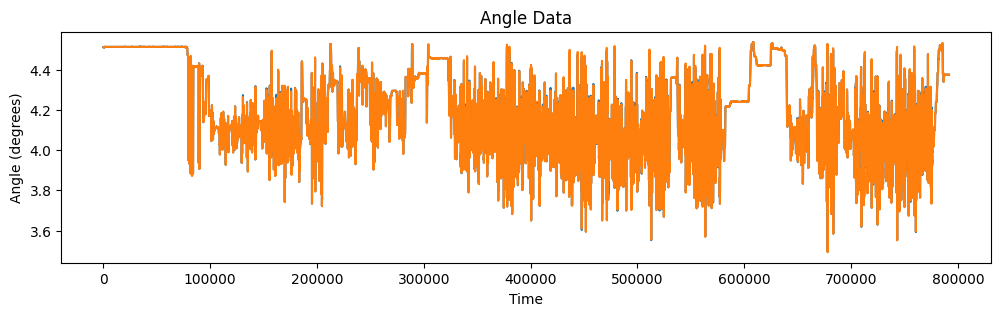

In [1292]:
# Plot filtered and unfiltered angle data
plt.figure(figsize=(12, 3))
plt.plot(time, angle_data)
plt.plot(time, angle_filtered)
plt.title("Angle Data")
plt.xlabel("Time")
plt.ylabel("Angle (degrees)")
plt.show()

0.14446315489373626
4.5129714779595576


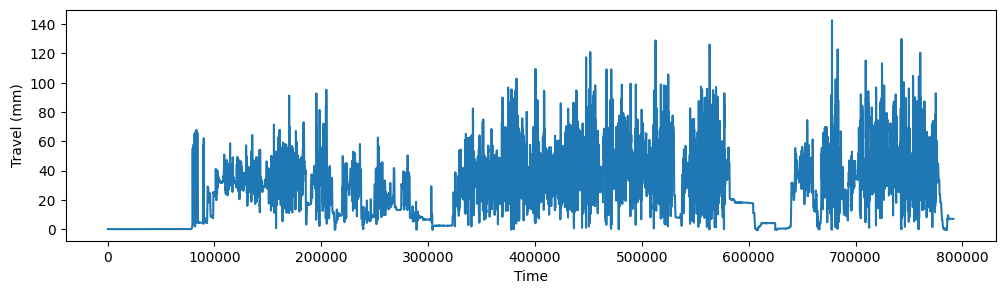

In [1293]:
# Get corrected angle, convert to travel
hypotenuse = 120
top_adjacent = 237.5 / 2

top_angle = np.arccos(top_adjacent / hypotenuse)
print(top_angle)
top_zeroangle = np.percentile(angle_filtered, 95)
print(top_zeroangle)
net_angle = -1 * (angle_filtered - top_zeroangle) + top_angle

# Convert angle to travel and plot 
travel = 2 * (top_adjacent - (hypotenuse * np.cos(net_angle)))
np.save(f"travel_{log_filename}.npy", travel)

# Plot filtered and unfiltered angle data
plt.figure(figsize=(12, 3))
plt.plot(time, travel)
plt.xlabel("Time")
plt.ylabel("Travel (mm)")
plt.show()


0.6409993933879284


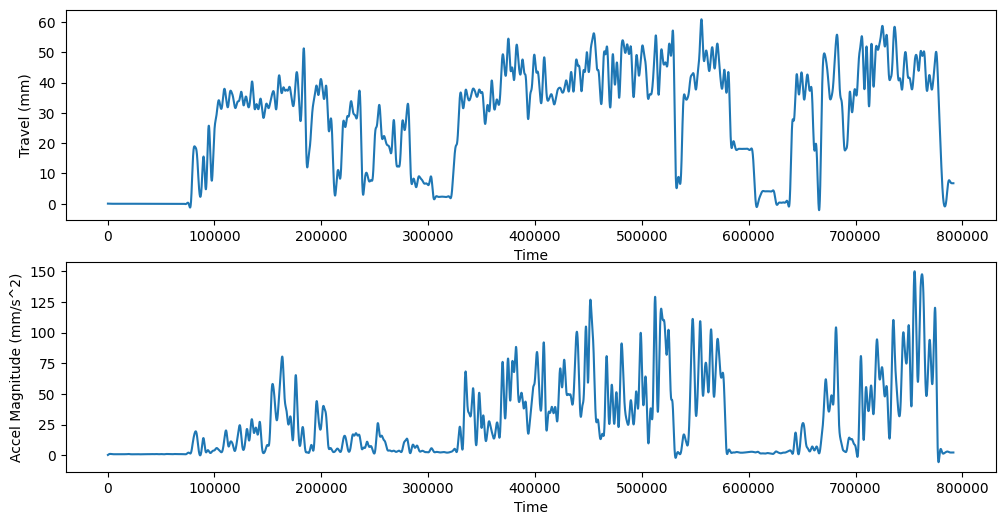

In [1294]:
# super lowpass travel for finding interesting regions
riding_travel_thresh = 25
fc_hz = 0.25
sos = butter(N=4, Wn=fc_hz, btype="low", fs=100, output="sos")
travel_lp = sosfiltfilt(sos, travel)
accel_mag_lp = sosfiltfilt(sos, abs(accel_proj[:, 0]))

riding_mask = travel_lp > riding_travel_thresh

print(np.where(riding_mask)[0].shape[0] / travel.shape[0])

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time, travel_lp)
plt.xlabel("Time")
plt.ylabel("Travel (mm)")
plt.subplot(2, 1, 2)
plt.plot(time, accel_mag_lp * (np.mean(travel_lp) / np.mean(accel_mag_lp)))
plt.xlabel("Time")
plt.ylabel("Accel Magnitude (mm/s^2)")
plt.show()

In [1295]:
# Threshold magnet data and find average direction of travel and project onto it
mag_threshold = 3000  # mG
print(mag_filtered.shape)
mag_filtered_thresh = mag_filtered[np.linalg.norm(mag_filtered, axis=1) > mag_threshold]
mean_vector = np.mean(mag_filtered_thresh, axis=0)
print(mean_vector)

# Project mag data onto mean vector to get travel along that direction
mag_travel_vector = mean_vector / np.linalg.norm(mean_vector)
print(mag_travel_vector)
mag_proj = mag_filtered @ mag_travel_vector

(79128, 3)
[-3481.87704583 -1174.90217417  3145.60517293]
[-0.71980957 -0.24288791  0.65029197]


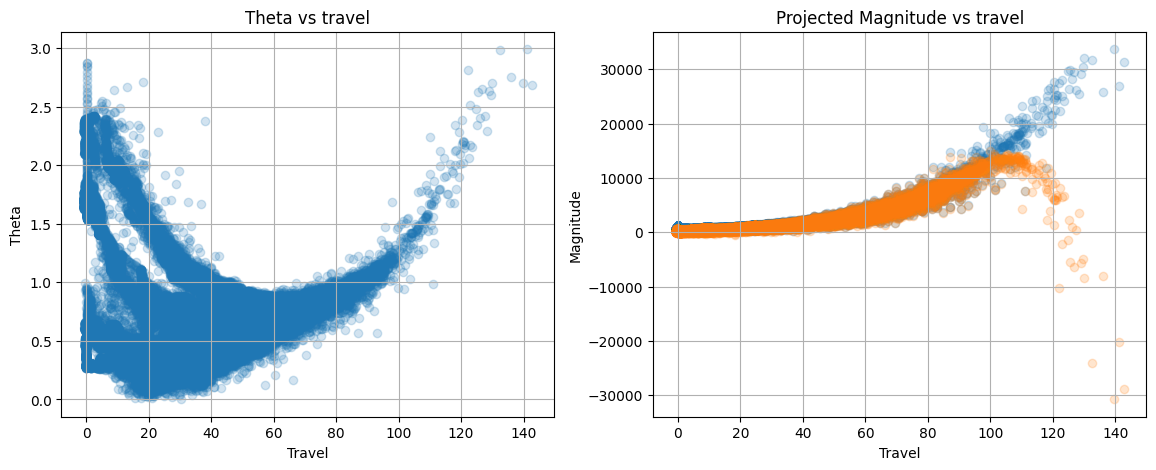

In [1296]:
# Plot scatter of magnet data vs travel
# Scatter plot of vectors
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.scatter(travel, mag_filt_sp[:, 1], alpha=0.2)
plt.title("Theta vs travel")
plt.xlabel("Travel")
plt.ylabel("Theta")
plt.grid()
# Plot scatter of projected mag vs travel
plt.subplot(1, 2, 2)
plt.scatter(travel, mag_filt_sp[:, 0], alpha=0.2)
plt.scatter(travel, mag_proj, alpha=0.2)
plt.title("Projected Magnitude vs travel")
plt.xlabel("Travel")
plt.ylabel("Magnitude")
plt.grid()
plt.show()

(14398,)
[ 0.00000000e+00  1.56026176e-02 -1.34929536e-06  4.87359934e-11] 20.826831487255305
RMSE: 22.740883959733395
RMSE (points over 1500): 3.332341249542711, Mean Abs Error: 2.4533746574735584
RMSE (points over 2000): 3.0481335490688313, Mean Abs Error: 2.0438504818474397
RMSE (points over 3000): 3.2878521601997375, Mean Abs Error: 1.9802281382588176


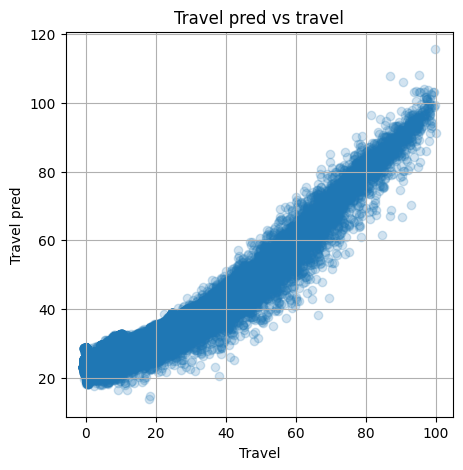

In [1297]:
# Fit polynomial to get travel from projected mag
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

def get_xy_by_xmin(x, y, xmin):
    x_mask = x > xmin
    xmasked = x[x_mask]
    ymasked = y[x_mask]
    return xmasked, ymasked

mag_scalar = mag_proj
#mag_scalar = mag_filt_sp[:, 0]
#mag_scalar = mag_proj + mag_filt_sp[:, 0]

min_mag = 2000
mag_m, travel_m = get_xy_by_xmin(mag_scalar, travel, min_mag)
print(mag_m.shape)

poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(mag_m.reshape(-1, 1))
model = LinearRegression()
model.fit(X_poly, travel_m)
mag_poly = poly.fit_transform(mag_scalar.reshape(-1, 1))
travel_pred = model.predict(mag_poly)
print(model.coef_, model.intercept_)

error = np.mean((travel - travel_pred) ** 2) ** 0.5
print(f"RMSE: {error}")

for mask_thresh in [1500, 2000, 3000]:
    min_mag_mask = mag_scalar > mask_thresh
    max_mag_mask = mag_scalar < (mask_thresh + 1000)
    mag_mask = min_mag_mask * max_mag_mask
    masked_travel = travel[mag_mask]
    masked_travel_pred = travel_pred[mag_mask]
    error_masked = np.mean((masked_travel - masked_travel_pred) ** 2) ** 0.5
    error_mean = np.mean(abs(masked_travel - masked_travel_pred))
    print(f"RMSE (points over {mask_thresh}): {error_masked}, Mean Abs Error: {error_mean}")

plt.figure(figsize=(5, 5))
plt.scatter(travel[travel < 100], travel_pred[travel < 100], alpha=0.2)
plt.title("Travel pred vs travel")
plt.xlabel("Travel")
plt.ylabel("Travel pred")
plt.grid()

Accel RMSE: 4.52774540866511
Low-passed accel Scale Error: 0.8723945876960271, rmse 1.050152025092873, dc offset -0.22696574368526526


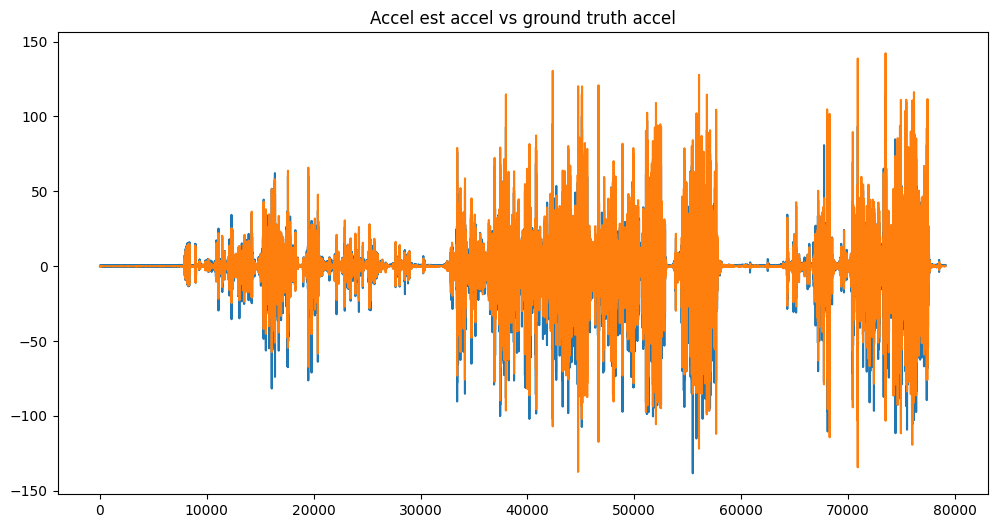

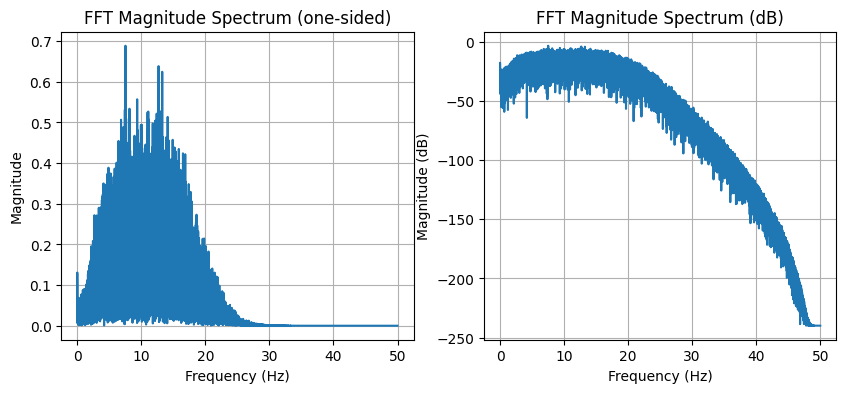

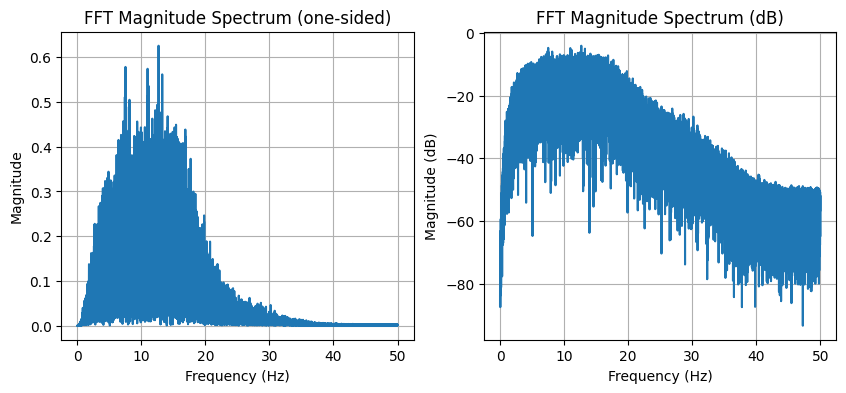

(array([0.00000000e+00, 1.26377515e-03, 2.52755030e-03, ...,
        4.99974724e+01, 4.99987362e+01, 5.00000000e+01], shape=(39565,)),
 array([4.45851607e-05, 1.41462000e-04, 1.15851974e-04, ...,
        1.80376986e-03, 2.55796886e-03, 1.48294610e-03], shape=(39565,)),
 array([-87.01619309, -76.98720404, -78.72193119, ..., -54.8763775 ,
        -51.84209493, -56.57749269], shape=(39565,)))

In [1298]:
# Now mess with accel data
dt_s = np.diff(time, prepend=time[0] - 10) / 1000.0

# Get ground truth acceleration by differentiating travel twice
gt_v = np.diff(travel, prepend=travel[0]) / dt_s / -1000 # convert to m/s
gt_a = np.diff(gt_v, prepend=gt_v[0]) / dt_s
rmse_a = np.mean((accel_proj[:, 0] - gt_a) ** 2) ** 0.5
print(f"Accel RMSE: {rmse_a}")

# Lowpass both accelerations and compare
fc_hz = 5
sos = butter(N=4, Wn=fc_hz, btype="low", fs=fs, output="sos")
gt_a_lp = sosfiltfilt(sos, gt_a, axis=0)
accel_proj_lp = sosfiltfilt(sos, accel_proj[:, 0], axis=0)
big_enough_accel = np.where(gt_a_lp > 20)
scale_error = np.mean(gt_a_lp[big_enough_accel] / accel_proj_lp[big_enough_accel])
lp_rmse = np.mean((gt_a_lp - accel_proj_lp) ** 2) ** 0.5
dc_offset = np.mean(gt_a_lp - accel_proj_lp)
print(f"Low-passed accel Scale Error: {scale_error}, rmse {lp_rmse}, dc offset {dc_offset}")

accel_proj_scaled = accel_proj * scale_error

plt.figure(figsize=(12,6))
# Plot accel vs time
plt.title("Accel est accel vs ground truth accel")
plt.plot(accel_proj[:, 0])
plt.plot(gt_a)


fft_and_histogram(accel_proj[:, 0], fs=100.0, detrend=True, window="hann",
                      hist_bins=80, hist_log=True, eps=1e-12)
fft_and_histogram(gt_a, fs=100.0, detrend=True, window="hann",
                      hist_bins=80, hist_log=True, eps=1e-12)


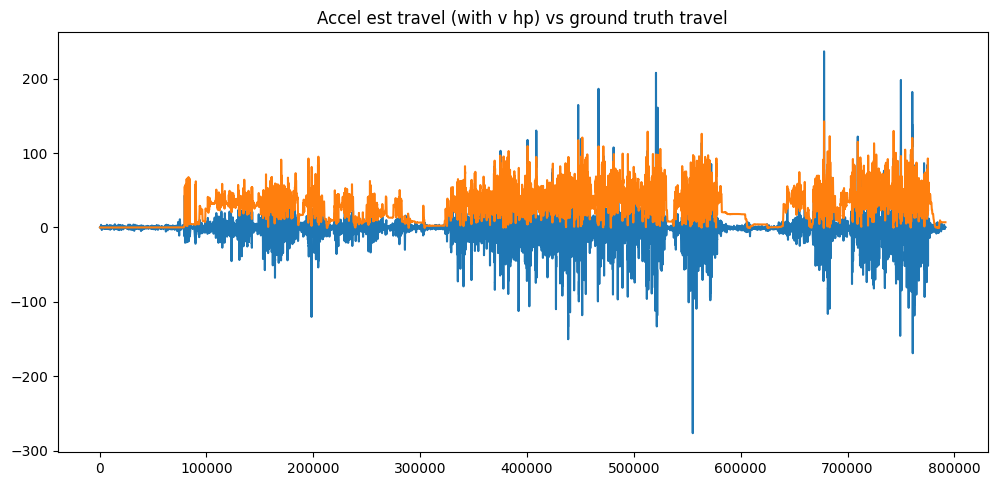

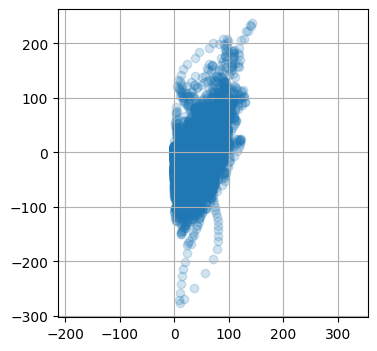

In [1299]:
# Get v and x and run an HPF on v
accel_x = accel_proj[:, 0] * -1000 # convert to mm/s^2 in travel direction

# HPF velocity and integrate to get position
# project velocity from accelerometer data
dv = accel_x * dt_s
v = np.cumsum(dv, axis=0)

# project position from velocity
dx = v * dt_s
x = np.cumsum(dx, axis=0)

# Lets try a HPF on velocity
fc_hz = 0.5
fs = 100

sos = butter(N=4, Wn=fc_hz, btype="high", fs=fs, output="sos")

v_hp = sosfiltfilt(sos, v, axis=0)
dx_hp = v_hp * dt_s
x_hp = np.cumsum(dx_hp, axis=0)
#a_hp = np.diff(v_hp, prepend=[0]) /  dt_s

# Plot displacement vs travel
plt.figure(figsize=(12, 12))
plt.subplot(2, 1, 1)
plt.title("Accel est travel (with v hp) vs ground truth travel")
plt.plot(time, x_hp)
plt.plot(time, travel)

plt.figure(figsize=(4, 4))
plt.scatter(travel, x_hp, alpha=0.2)
plt.axis("equal")
plt.grid()

In [1300]:
# Find points where magnet signal crosses threshold
mag_crossing_thresh = 1500
s = mag_scalar - mag_crossing_thresh
mag_crossings = np.nonzero((s[:-1] * s[1:]) < 0)[0]   # pairs (i, i+1) straddle

print(f"Crossing points: {len(mag_crossings)}")

# Predict travel at the threshold
mag_poly = poly.fit_transform(np.array(mag_crossing_thresh).reshape(1, -1))
travel_at_thresh = model.predict(mag_poly)[0]
print("Travel at thresh:", travel_at_thresh)


Crossing points: 1950
Travel at thresh: 41.35932728072758


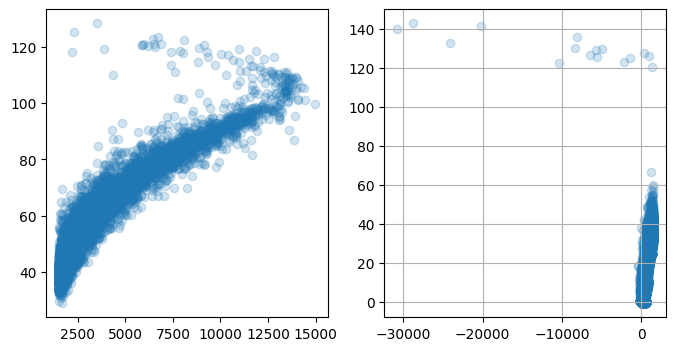

In [1301]:
# Plot where travel ranges above and below mag thresh
above_thresh = np.where(s > 0)
below_thresh = np.where(s < 0)

travel_above_thresh = travel[above_thresh]
mag_above_thresh = mag_scalar[above_thresh]

travel_below_thresh = travel[below_thresh]
mag_below_thresh = mag_scalar[below_thresh]

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.scatter(mag_above_thresh, travel_above_thresh, alpha=0.2)
plt.subplot(1, 2, 2)
plt.scatter(mag_below_thresh, travel_below_thresh, alpha=0.2)
plt.grid()


Mag travel mean error 4.259300810095685
Uncorrected accel travel mean error 29.385696528532584
Acc integration travel w/o correction RMSE: 46.445, MAE: 41.259, ME: -40.318
Acc integration travel wit correction RMSE: 12.721, MAE: 7.686, ME: 1.700
Acc integration travel w/o correction in slice RMSE: 14.857, MAE: 12.768, ME: -12.261
Acc integration travel wit correction in slice RMSE: 6.227, MAE: 4.853, ME: 1.242


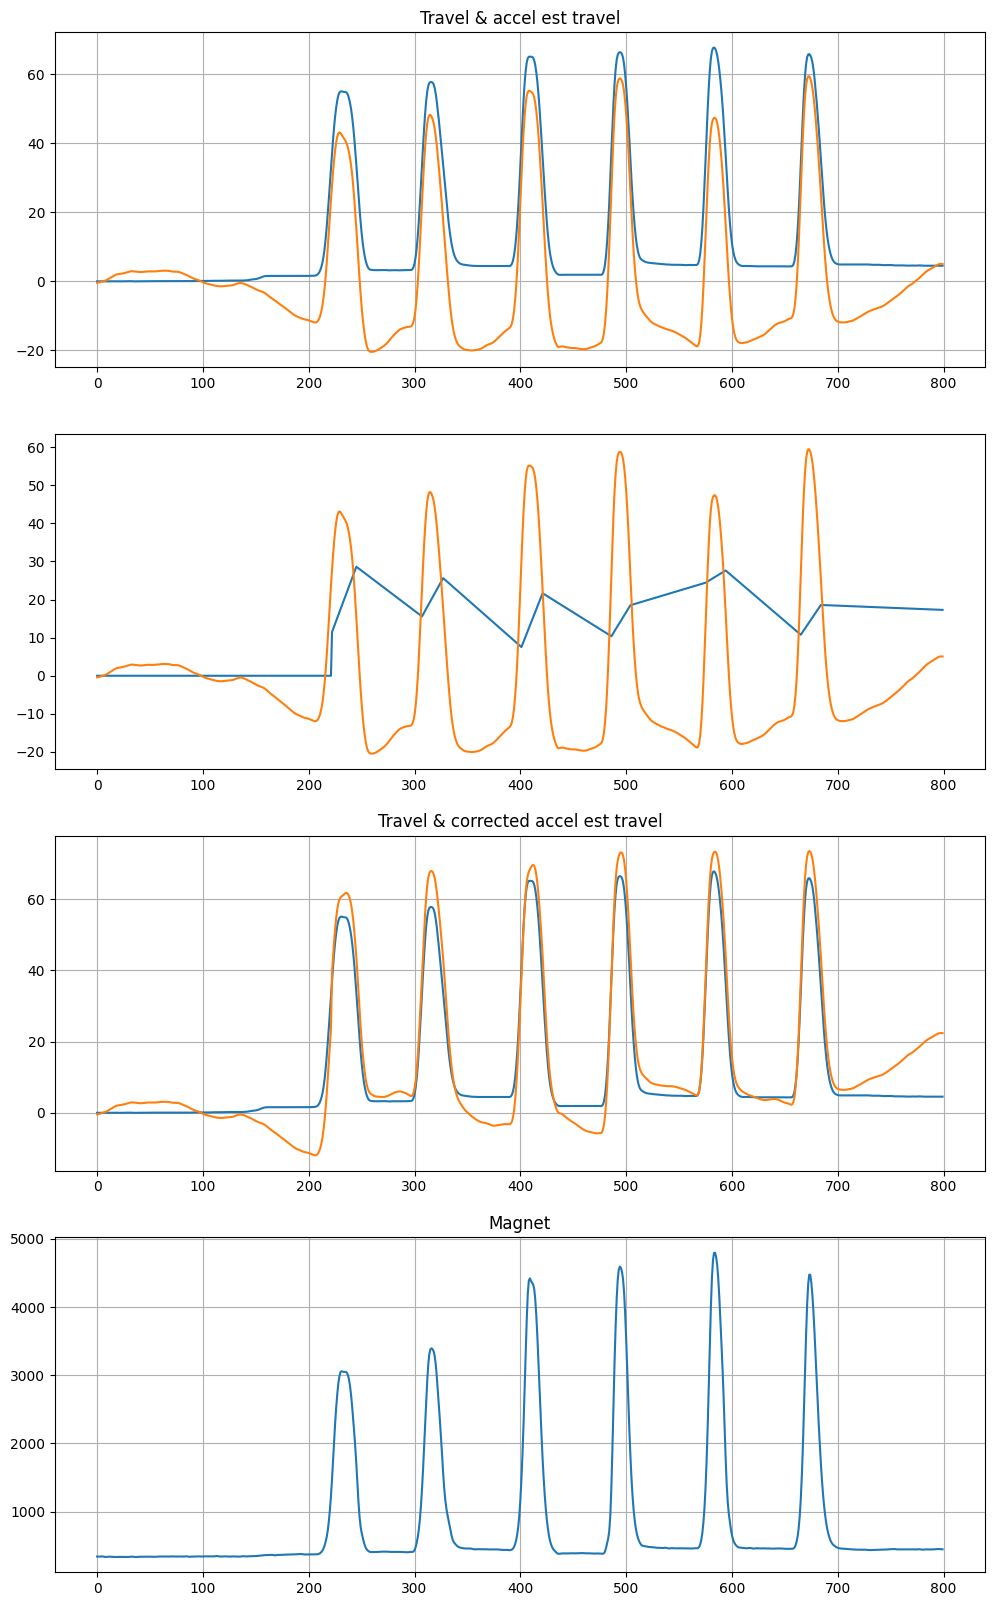

In [1302]:
# Get accelerometer predictions at the crossing points and use for linear interpolation
acc_trav = x_hp
x_preds = (acc_trav[mag_crossings] + acc_trav[mag_crossings + 1]) / 2
x_actual = (travel[mag_crossings] + travel[mag_crossings + 1]) / 2
errors = x_actual - travel_at_thresh
print("Mag travel mean error", np.mean(abs(errors)))
print("Uncorrected accel travel mean error", np.mean(abs(travel - acc_trav)))
error_guess = travel_at_thresh - x_preds

from scipy.interpolate import interp1d
# Create the error fit equation
f = interp1d(mag_crossings, error_guess, kind="linear", bounds_error=False, fill_value=0)

corr = f(np.arange(len(time)))
acc_trav_corr = acc_trav + corr

print_err_stats(acc_trav[riding_mask], travel[riding_mask], "Acc integration travel w/o correction")
print_err_stats(acc_trav_corr[riding_mask], travel[riding_mask], "Acc integration travel wit correction")

#slice_i = slice(4#0000, 41000)
#slice_i = slice(45000, 50000)
#slice_i = slice(15000, 16000)
slice_i = slice(7700, 8500)

print_err_stats(acc_trav[slice_i], travel[slice_i], "Acc integration travel w/o correction in slice")
print_err_stats(acc_trav_corr[slice_i], travel[slice_i], "Acc integration travel wit correction in slice")

# Plot filtered and unfiltered angle data
plt.figure(figsize=(12, 20))
plt.subplot(4, 1, 1)
plt.title("Travel & accel est travel")
plt.plot(travel[slice_i])
plt.plot(acc_trav[slice_i])
plt.grid()
plt.subplot(4, 1, 2)
plt.plot(corr[slice_i])
plt.plot(acc_trav[slice_i])
plt.subplot(4, 1, 3)
plt.title("Travel & corrected accel est travel")
plt.plot(travel[slice_i])
plt.plot(acc_trav_corr[slice_i])
plt.grid()
plt.subplot(4, 1, 4)
#plt.title("Travel minus corrected accel est travel")
#plt.plot(abs(travel[slice_i] - acc_trav_corr[slice_i]))
plt.title("Magnet")
plt.plot(mag_scalar[slice_i])
plt.grid()
plt.show()

Points in mag bounds: 31563 out of 79128 (0.39888535031847133)
[0.         0.01623541] 13.675606106487987
mag to travel poly X (in bounds) RMSE: 3.240, MAE: 2.321, ME: -0.000
mag to travel poly V (in bounds) RMSE: 148.645, MAE: 51.412, ME: -8.242
highpass V (in bounds) RMSE: 102.486, MAE: 63.273, ME: -1.354


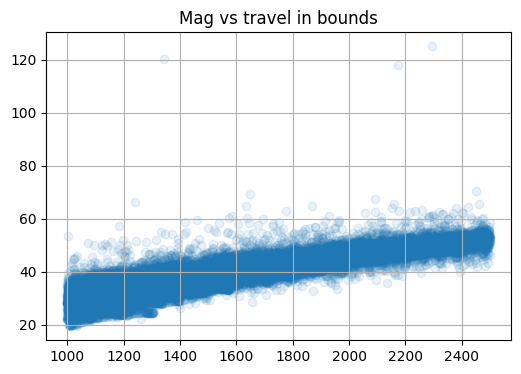

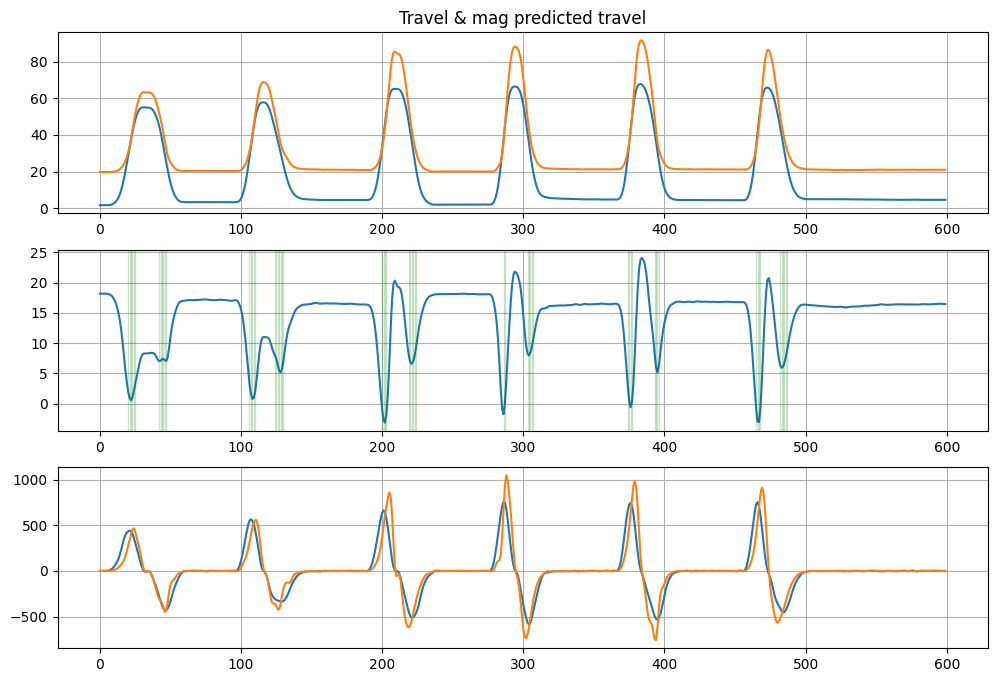

In [ ]:
# Try more advanced correction w/ continuous position and velocity from magnet in the cal region

mag_scalar = mag_proj
#mag_scalar = mag_filt_sp[:, 0]

def get_xy_by_xbounds(x, y, xbounds):
    x_mask = x > xbounds[0]
    x_mask *= x < xbounds[1]
    xmasked = x[x_mask]
    ymasked = y[x_mask]
    return xmasked, ymasked, x_mask

mag_cal_bounds = [1000, 2500]

mag_m, travel_m, mask = get_xy_by_xbounds(mag_scalar, travel, mag_cal_bounds)

print(f"Points in mag bounds: {mag_m.shape[0]} out of {mag_scalar.shape[0]} ({mag_m.shape[0]/mag_scalar.shape[0]})")

plt.figure(figsize=(6, 4))
plt.title("Mag vs travel in bounds")
plt.scatter(mag_m, travel_m, alpha=0.1)
plt.grid()

poly = PolynomialFeatures(degree=1)
X_poly = poly.fit_transform(mag_m.reshape(-1, 1))
model = LinearRegression()
model.fit(X_poly, travel_m)
mag_poly = poly.fit_transform(mag_scalar.reshape(-1, 1))
trav_pred_2 = model.predict(mag_poly)
print(model.coef_, model.intercept_)

print_err_stats(trav_pred_2[mask], travel[mask], "mag to travel poly X (in bounds)")

# dt per sample (len N, dt[0]=0 or dt[0]=dt[1] is typical)
dt_s = np.diff(time_s, prepend=time_s[0] - 0.01)
v_gt = np.diff(travel, prepend=travel[0]) / dt_s
v_magnet = np.diff(trav_pred_2, prepend=trav_pred_2[0]) / dt_s
print_err_stats(v_magnet[mask], v_gt[mask], "mag to travel poly V (in bounds)")
print_err_stats(v_hp[mask], v_gt[mask], "highpass V (in bounds)")

slice_i = slice(7900, 8500)

plt.figure(figsize=(12,12))
plt.subplot(4, 1, 1)
plt.title("Travel & mag predicted travel")
plt.plot(travel[slice_i])
plt.plot(trav_pred_2[slice_i])
plt.grid()
plt.subplot(4, 1, 2)
plt.plot(trav_pred_2[slice_i] - travel[slice_i])
for idx in range(slice_i.start, slice_i.stop):
    if mask[idx]:
        plt.axvline(idx - slice_i.start, color='green', lw=1, alpha=0.2)
plt.grid()
plt.subplot(4, 1, 3)
plt.plot(v_gt[slice_i])
plt.plot(v_magnet[slice_i])
plt.grid()
plt.subplot(4, 1, 4)
plt.plot(accel_x[slice_i])
plt.grid()

10000 23.970155102828002
18000 52.52608855267383
23000 114.47253643938058
27000 119.7405829763736
44000 151.2907029319152
46000 312.15171008009054
70000 486.7087539885342
new travel guess RMSE: 6.758, MAE: 3.441, ME: -0.447


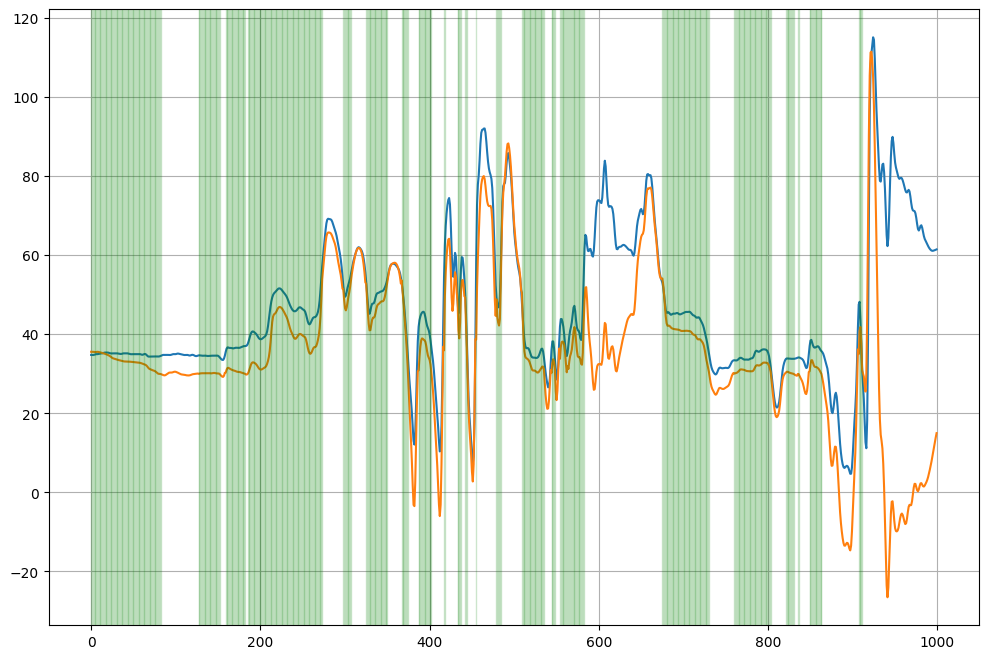

In [1319]:
# Now do a loop-based position estimate with the smart magnety thing
v_orig = v_hp # Use the highpassed velocity
mag_x = trav_pred_2

x_i = 0
x_loop = np.zeros_like(travel)

last_correction = 0

for i in range(x_loop.shape[0]):
    x_correction = False
    if mag_cal_bounds[0] <= mag_scalar[i] <= mag_cal_bounds[1]:
        x_correction = True
        correct_x = mag_x[i]
    elif x_i < 0:
        #x_correction = True
        correct_x = 0
    elif x_i > 170:
        #x_correction = True
        correct_x = 170

    if x_correction:
        if i > (last_correction + 1):
            # Didn't just correct so interpolate to smooth out correction
            d_i = i - last_correction
            error = x_i - correct_x
            for i2 in range(d_i):
                x_loop[i2 + last_correction] -= error * i2 / d_i
        # use x from magnet algo
        x_i = correct_x
        last_correction = i
    else:
        x_i += v_orig[i] * dt_s[i]
    x_loop[i] = x_i

slice_len = 1000
max_error = 0
max_error_idx = 0
for slice_idx in range(0, x_loop.shape[0], slice_len):
    slice_i = slice(slice_idx, slice_idx + slice_len)
    x_slice = x_loop[slice_i]
    trav_slice = travel[slice_i]
    mae = np.mean((x_slice - trav_slice) ** 2)
    if mae > max_error and np.mean(trav_slice) > 20:
        max_error_idx = slice_idx
        max_error = mae
        print(max_error_idx, max_error)

#slice_i = slice(7900, 8500)
#slice_i = slice(51700, 52500)
#slice_i = slice(51000, 53000)
slice_i = slice(max_error_idx, max_error_idx + slice_len)

plt.figure(figsize=(12,8))
plt.plot(travel[slice_i])
plt.plot(x_loop[slice_i])
for idx in range(slice_i.start, slice_i.stop):
    if mask[idx]:
        plt.axvline(idx - slice_i.start, color='green', lw=1, alpha=0.2)
plt.grid()

print_err_stats(x_loop[riding_mask], travel[riding_mask], "new travel guess")

highpass V RMSE: 108.908, MAE: 57.536, ME: -0.008
corrected V RMSE: 124.797, MAE: 47.594, ME: 0.033


/var/folders/gh/w4m5xvvx3pb1xzs57mkz_5j00000gn/T/ipykernel_5949/3693841093.py:21: RuntimeWarning: divide by zero encountered in log10
  logv = np.log10(v_gt)
/var/folders/gh/w4m5xvvx3pb1xzs57mkz_5j00000gn/T/ipykernel_5949/3693841093.py:21: RuntimeWarning: invalid value encountered in log10
  logv = np.log10(v_gt)
/var/folders/gh/w4m5xvvx3pb1xzs57mkz_5j00000gn/T/ipykernel_5949/3693841093.py:22: RuntimeWarning: divide by zero encountered in log10
  logv_corr = np.log10(v_corr)
/var/folders/gh/w4m5xvvx3pb1xzs57mkz_5j00000gn/T/ipykernel_5949/3693841093.py:22: RuntimeWarning: invalid value encountered in log10
  logv_corr = np.log10(v_corr)


(array([   3.,    3.,    4.,    7.,   11.,   22.,   29.,   36.,   74.,
         102.,  151.,  238.,  362.,  569.,  788., 1106., 1415., 1550.,
        1833., 2099., 2192., 2512., 2680., 2793., 2288., 1715., 1121.,
         556.,  286.,   49.]),
 array([-2.36869021, -2.17404927, -1.97940834, -1.7847674 , -1.59012646,
        -1.39548553, -1.20084459, -1.00620366, -0.81156272, -0.61692179,
        -0.42228085, -0.22763991, -0.03299898,  0.16164196,  0.35628289,
         0.55092383,  0.74556477,  0.9402057 ,  1.13484664,  1.32948757,
         1.52412851,  1.71876945,  1.91341038,  2.10805132,  2.30269225,
         2.49733319,  2.69197412,  2.88661506,  3.081256  ,  3.27589693,
         3.47053787]),
 <BarContainer object of 30 artists>)

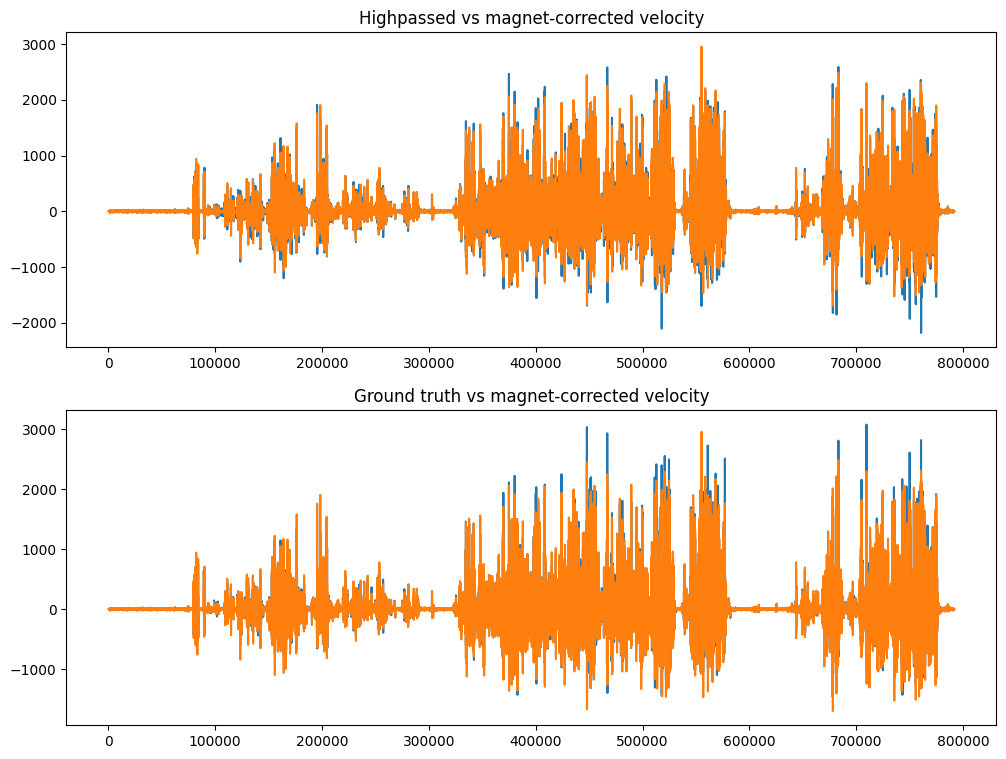

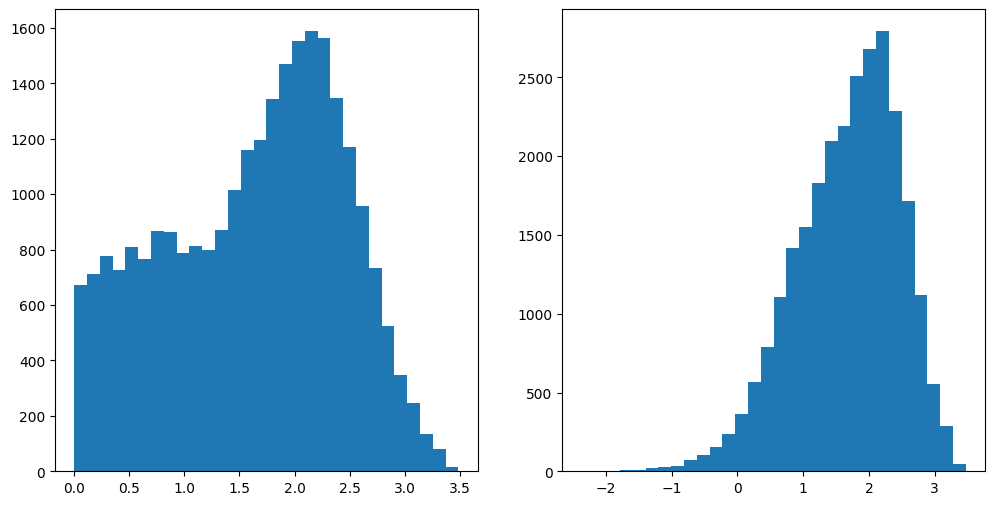

In [1344]:
# Calculate new V estimate after correction
v_corr = np.diff(x_loop, prepend=x_loop[0]) / dt_s
v_gt = np.diff(travel, prepend=travel[0]) / dt_s

slice_idx = slice(0, -1) #slice(idx[0] + 1, idx[-1])

plt.figure(figsize=(12, 9))
plt.subplot(2, 1, 1)
plt.title("Highpassed vs magnet-corrected velocity")
plt.plot(time[slice_idx], v_hp[slice_idx])
plt.plot(time[slice_idx], v_corr[slice_idx])
plt.subplot(2, 1, 2)
plt.title("Ground truth vs magnet-corrected velocity")
plt.plot(time[slice_idx], v_gt[slice_idx])
plt.plot(time[slice_idx], v_corr[slice_idx])

print_err_stats(v_hp, v_gt, "highpass V")
print_err_stats(v_corr, v_gt, "corrected V")

v_mask = abs(v_gt) > 1
logv = np.log10(v_gt)
logv_corr = np.log10(v_corr)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(logv[v_mask], bins=30)
plt.subplot(1, 2, 2)
plt.hist(logv_corr[v_mask], bins=30)

4527.74540866511 4489.874480852686


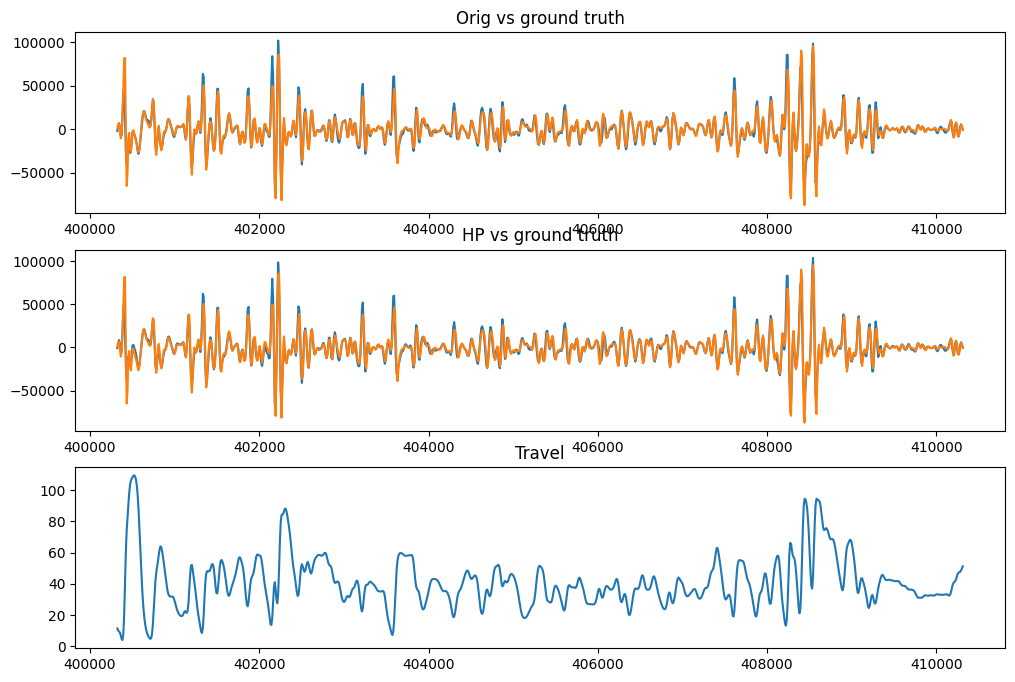

In [1345]:
# Try highpassing acceleration
gt_a_mm_s = gt_a * -1000

fc_hz = 2
fs = 100

sos = butter(N=4, Wn=fc_hz, btype="high", fs=fs, output="sos")

a_hp = sosfiltfilt(sos, accel_x, axis=0)

slice_i = slice(40000, 41000)

plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.title("Orig vs ground truth")
plt.plot(time[slice_i], accel_x[slice_i])
plt.plot(time[slice_i], gt_a_mm_s[slice_i])
plt.subplot(3, 1, 2)
plt.title("HP vs ground truth")
plt.plot(time[slice_i], a_hp[slice_i])
plt.plot(time[slice_i], gt_a_mm_s[slice_i])
plt.subplot(3, 1, 3)
plt.title("Travel")
plt.plot(time[slice_i], travel[slice_i])

rmse_a = np.mean((accel_x - gt_a_mm_s) ** 2) ** 0.5
rmse_a_hp = np.mean((a_hp - gt_a_mm_s) ** 2) ** 0.5

print(rmse_a, rmse_a_hp)